<a href="https://colab.research.google.com/github/hscrown/madatpublicdata/blob/main/%EB%8B%A4%EC%B8%B5_%ED%8D%BC%EC%85%89%ED%8A%B8%EB%A1%A0(MLP)%EC%9D%84_%EC%82%AC%EC%9A%A9%ED%95%9C_%EA%B0%84%EB%8B%A8%ED%95%9C_%ED%8F%89%EC%A0%90_%EC%98%88%EC%B8%A1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 데이터 로드 및 전처리
df = pd.read_csv('user_rating_1000.csv')

# 사용자와 장소 ID를 범주형으로 인코딩
user_ids = df['user_id'].astype('category').cat.codes.values
place_ids = df['place_id'].astype('category').cat.codes.values

# 평점을 정규화
scaler = StandardScaler()
ratings = scaler.fit_transform(df['rating'].values.reshape(-1, 1)).flatten()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[['user_id', 'place_id']], ratings, test_size=0.2, random_state=42)


# 모델 구성
embedding_dim = 50
num_users = len(df['user_id'].unique())
num_places = len(df['place_id'].unique())

user_input = tf.keras.layers.Input(shape=(1,))
place_input = tf.keras.layers.Input(shape=(1,))

user_embedding = tf.keras.layers.Embedding(num_users, embedding_dim)(user_input)
place_embedding = tf.keras.layers.Embedding(num_places, embedding_dim)(place_input)

concat = tf.keras.layers.concatenate([user_embedding, place_embedding])
flatten = tf.keras.layers.Flatten()(concat)
dense1 = tf.keras.layers.Dense(64, activation='relu')(flatten)
dense2 = tf.keras.layers.Dense(32, activation='relu')(dense1)
output = tf.keras.layers.Dense(1)(dense2)

model = tf.keras.models.Model(inputs=[user_input, place_input], outputs=output)
model.compile(optimizer='adam', loss='mse')

# 모델 훈련
model.fit([X_train['user_id'], X_train['place_id']], y_train, epochs=10, batch_size=64, validation_split=0.2)

# 성능 평가
test_loss = model.evaluate([X_test['user_id'], X_test['place_id']], y_test)
print("Test Loss:", test_loss)

# 평점이 0인 데이터에 대한 예측
zero_ratings = df[df['rating'] == 0]
user_ids = zero_ratings['user_id'].astype('category').cat.codes.values
place_ids = zero_ratings['place_id'].astype('category').cat.codes.values
predicted_ratings = model.predict([user_ids, place_ids]).flatten()
zero_ratings['predicted_rating'] = scaler.inverse_transform(predicted_ratings.reshape(-1, 1))

print("Predicted ratings for zero ratings:")
print(zero_ratings[['user_id', 'place_id', 'predicted_rating']])


Epoch 1/10
16630/16630 [==============================] - 69s 4ms/step - loss: 1.0002 - val_loss: 0.9968
Epoch 2/10
16630/16630 [==============================] - 67s 4ms/step - loss: 1.0000 - val_loss: 0.9968
Epoch 3/10
16630/16630 [==============================] - 61s 4ms/step - loss: 0.9997 - val_loss: 0.9972
Epoch 4/10
16630/16630 [==============================] - 68s 4ms/step - loss: 0.9983 - val_loss: 0.9989
Epoch 5/10
16630/16630 [==============================] - 63s 4ms/step - loss: 0.9959 - val_loss: 1.0001
Epoch 6/10
16630/16630 [==============================] - 61s 4ms/step - loss: 0.9925 - val_loss: 1.0025
Epoch 7/10
16630/16630 [==============================] - 61s 4ms/step - loss: 0.9882 - val_loss: 1.0042
Epoch 8/10
16630/16630 [==============================] - 64s 4ms/step - loss: 0.9832 - val_loss: 1.0103
Epoch 9/10
16630/16630 [==============================] - 62s 4ms/step - loss: 0.9781 - val_loss: 1.0148
Epoch 10/10
10394/10394 [==============================

<ipython-input-10-346d6d6e2614>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zero_ratings['predicted_rating'] = scaler.inverse_transform(predicted_ratings.reshape(-1, 1))


In [13]:
# 사용자 ID가 0인 데이터 선택
user_id_0_data = df[df['user_id'] == 0]

# 사용자 ID가 0인 데이터의 아이템 ID 추출
user_id_0_item_ids = user_id_0_data['place_id'].astype('category').cat.codes.values

# 해당 사용자의 평점 예측
predicted_ratings_user_0 = model.predict([np.array([0]*len(user_id_0_item_ids)), user_id_0_item_ids]).flatten()
predicted_ratings_user_0 = scaler.inverse_transform(predicted_ratings_user_0.reshape(-1, 1)).flatten()

# 실제 평점과 예측 평점 비교
for i, (actual, predicted) in enumerate(zip(user_id_0_data['rating'], predicted_ratings_user_0)):
    print(f"Actual Rating: {actual}, Predicted Rating: {predicted}")


52/52 [==============================] - 0s 4ms/step
Actual Rating: 4.5, Predicted Rating: 3.3100132942199707
Actual Rating: 2.5, Predicted Rating: 3.3100132942199707
Actual Rating: 2.5, Predicted Rating: 3.500352144241333
Actual Rating: 2.5, Predicted Rating: 3.327016592025757
Actual Rating: 2.0, Predicted Rating: 3.3183794021606445
Actual Rating: 3.0, Predicted Rating: 2.9402222633361816
Actual Rating: 4.5, Predicted Rating: 3.669297218322754
Actual Rating: 3.0, Predicted Rating: 3.195742607116699
Actual Rating: 5.0, Predicted Rating: 3.6336300373077393
Actual Rating: 4.5, Predicted Rating: 3.3100132942199707
Actual Rating: 5.0, Predicted Rating: 3.3100132942199707
Actual Rating: 4.0, Predicted Rating: 3.24092698097229
Actual Rating: 3.0, Predicted Rating: 3.3100132942199707
Actual Rating: 4.5, Predicted Rating: 3.465039014816284
Actual Rating: 4.0, Predicted Rating: 3.515178680419922
Actual Rating: 3.0, Predicted Rating: 3.3100132942199707
Actual Rating: 5.0, Predicted Rating: 3.310

51969/51969 [==============================] - 87s 2ms/step


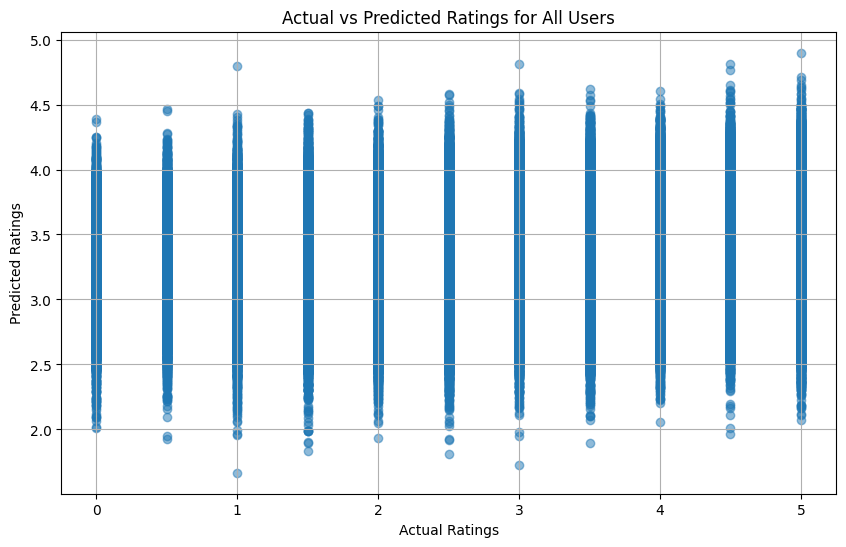

In [14]:
import matplotlib.pyplot as plt

# 전체 사용자의 실제 평점과 예측 평점 비교
actual_ratings_all_users = df['rating'].values
predicted_ratings_all_users = model.predict([df['user_id'], df['place_id']]).flatten()
predicted_ratings_all_users = scaler.inverse_transform(predicted_ratings_all_users.reshape(-1, 1)).flatten()

# 산점도로 시각화
plt.figure(figsize=(10, 6))
plt.scatter(actual_ratings_all_users, predicted_ratings_all_users, alpha=0.5)
plt.title('Actual vs Predicted Ratings for All Users')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.grid(True)
plt.show()


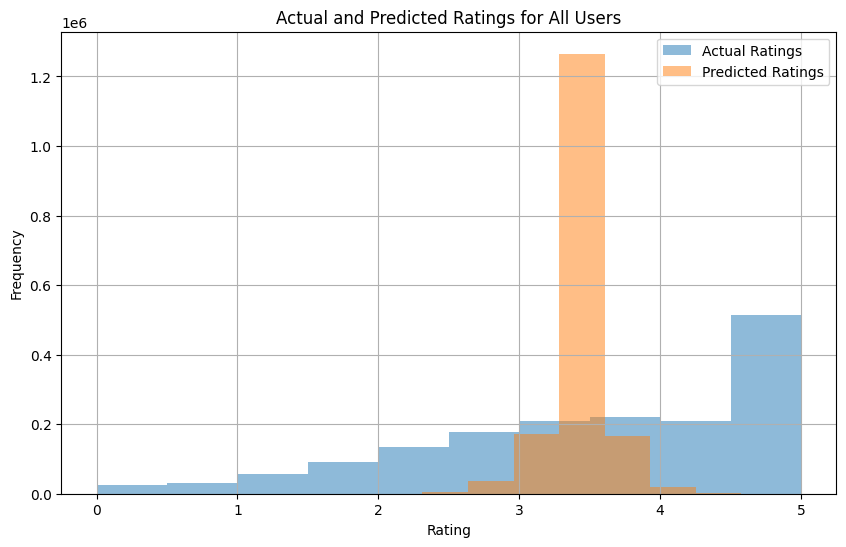

In [16]:
# 히스토그램으로 시각화
plt.figure(figsize=(10, 6))
plt.hist(actual_ratings_all_users, bins=10, alpha=0.5, label='Actual Ratings')
plt.hist(predicted_ratings_all_users, bins=10, alpha=0.5, label='Predicted Ratings')
plt.title('Actual and Predicted Ratings for All Users')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()
